# Airbus Ship-Detection – Data Exploration Notebook #

The Airbus Ship-Detection database contains various satelite images alongside encoded masks for the ships in each picture. The masks are presented in a csv file with rle encoding where each line encodes the corresponding pixels for one ship in one picture. The Data_loader.py module decodes this file and makes a tensor for every image that contains the final mask (0 - no ship in that pixel, 1 - pixel is part of a ship).

The number of ships on an image can vary, in fact a large chunk of the images doesn't contain ships at all. This notebook contains some basic data visualization and exploration of this dataset.

### Imports  ### 

In [38]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path

notebook_dir = Path.cwd()
repo_root = notebook_dir.parent
sys.path.insert(0, str(repo_root))

from src.data_loader import ShipDatasetLoader
from src.preprocessor import ShipPreprocessor
from config import (
    TRAIN_IMAGES_DIR,
    TRAIN_METADATA_CSV,
    IMG_SIZE,
    RANDOM_SEED,
)

### Creating dataframe ###

NaN in EncodedPixels means there are no ships in the picture.

In [39]:
df = pd.read_csv(TRAIN_METADATA_CSV)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### Basic metrics ###

In [40]:
print(f"Number of csv entries: {len(df)}")
df_grouped = df.groupby('ImageId')
print(f"Number of images: {len(df_grouped)}")
df['EncodedPixels'].isna()
print(f"Number of images without ships: {len(df[df['EncodedPixels'].isna()])}")

Number of csv entries: 231723
Number of images: 192556
Number of images without ships: 150000


### Number of ships on the images ###

In [41]:
df_shipcount = df.copy()
df_shipcount['ShipCount'] = 0
df_shipcount.loc[df_shipcount['EncodedPixels'].notna(), 'ShipCount'] = 1
df_shipcount = df_shipcount.drop(columns=['EncodedPixels'], axis=1)
df_shipcount = df_shipcount.groupby('ImageId').agg({
           'ShipCount': 'sum'
       }).reset_index()

df_shipcount = df_shipcount['ShipCount'].value_counts().reset_index()
df_shipcount.columns = ['ShipCount', 'ImageCount']
df_shipcount

,ShipCount,ImageCount
0,0,150000
1,1,27104
2,2,7674
3,3,2954
4,4,1622
5,5,925
6,6,657
7,7,406
8,8,318
9,9,243


In [42]:
px.bar(
    df_shipcount,
    x='ShipCount',
    y='ImageCount',
    title="Number of Images per Ship Count",
    labels={'ShipCount': 'Number of Ships', 'ImageCount': 'Number of Images'},
    log_y=True
)

In [43]:
fig_pie = px.pie(
    df_shipcount,
    values='ImageCount',
    names='ShipCount',
    title="Distribution of Ship Counts per Image",
    
)
fig_pie.update_traces(textposition='inside')
fig_pie.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig_pie

### Image visualizuation ###

Found 192,556 training images


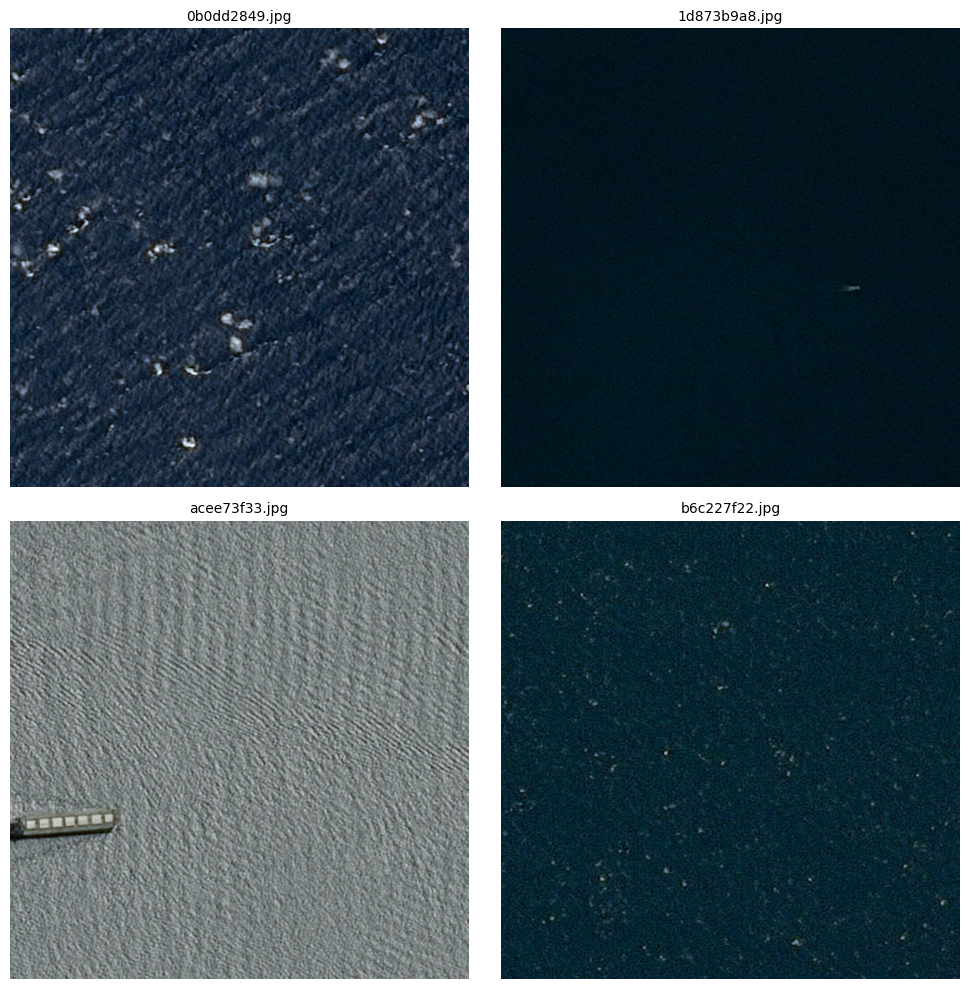

In [44]:
import random

train_img_dir = Path(TRAIN_IMAGES_DIR)

jpg_files = list(train_img_dir.glob("*.jpg"))
print(f"Found {len(jpg_files):,} training images")

#random.seed(RANDOM_SEED)
sample_files = random.sample(jpg_files, k=4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), sample_files):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(img_path.name, fontsize=10)
    ax.axis("off")                        

plt.tight_layout()
plt.show()

### Mask visualization ###

In [45]:
# Init data loader

loader = ShipDatasetLoader(
    train_image_dir=TRAIN_IMAGES_DIR,
    masks_csv_path=TRAIN_METADATA_CSV,
    img_size=IMG_SIZE
)

Dataset statistics:
  Total unique images: 192556
  Images with ships: 42556
  Images without ships: 150000


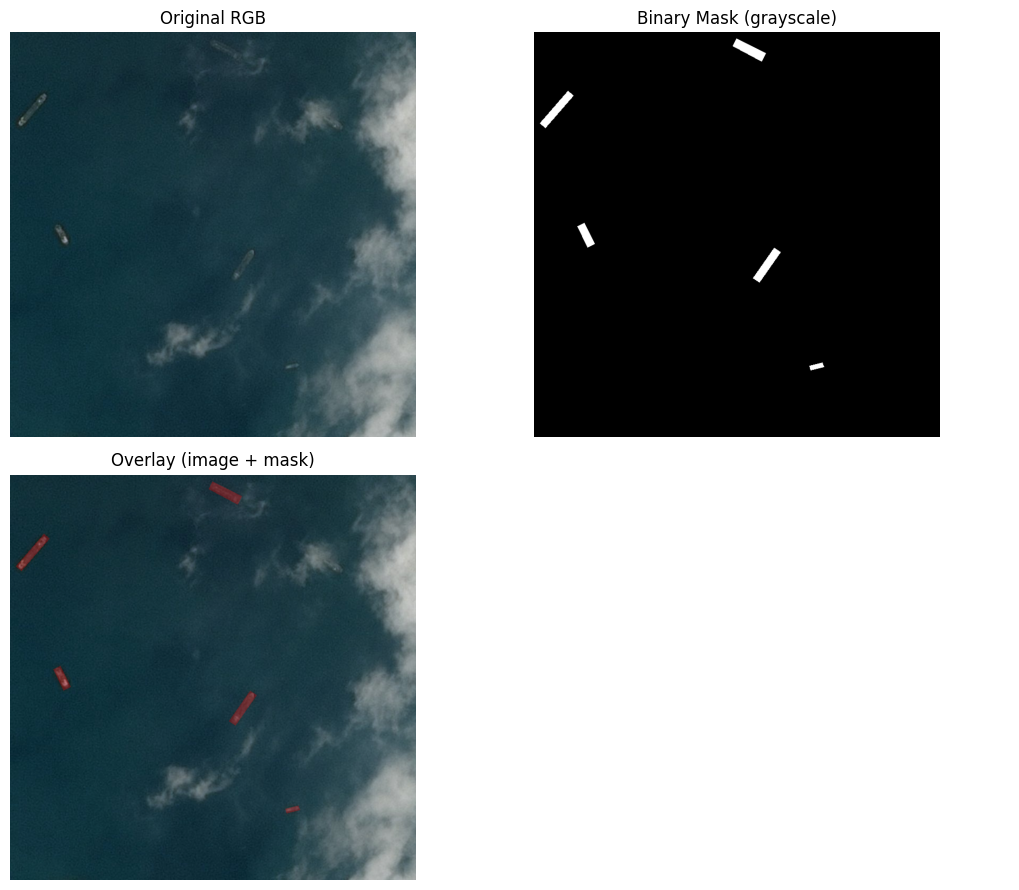

In [46]:
IMG_ID = "093962312.jpg"
img_path = Path(TRAIN_IMAGES_DIR) / IMG_ID

# image
img = plt.imread(img_path)

row = loader.df_grouped[loader.df_grouped['ImageId'] == IMG_ID]
rle_list = row['EncodedPixels'].iloc[0]

# mask
mask = loader.combine_masks(rle_list, original_shape=(768, 768))

# image + mask overlay
overlay = img.copy()
overlay[mask == 1] = [255, 0, 0]  # red ships
overlay = 0.3 * overlay + 0.7 * img.astype(np.float32)
overlay = overlay.astype(np.uint8)

fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Row 1
axes[0,0].imshow(img)
axes[0,0].set_title("Original RGB")
axes[0,0].axis("off")

axes[0,1].imshow(mask, cmap="gray")
axes[0,1].set_title("Binary Mask (grayscale)")
axes[0,1].axis("off")

# Row 2
axes[1,0].imshow(overlay)
axes[1,0].set_title("Overlay (image + mask)")
axes[1,0].axis("off")

# Hide unused
axes[1,1].axis("off")

plt.tight_layout()
plt.show()

### Data augmentations ###

We are going to use 2 types of data augmentation method. One is the standard randomized augmentation during training, the other is a deterministic one for test-time augmentation which can help the performance of the model during inference.

Since this is a segmentation task, it's important that any time we do an augmentation on an image, the related mask should still be correct and mark the correct pixels.

In [47]:
# Preparation to use prepocessor

import tensorflow as tf

prep = ShipPreprocessor(img_size=(768, 768))

img = tf.io.read_file(str(img_path))
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)

mask = tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)

In [ ]:
# helper to make overlay

def make_overlay(image, mask, alpha=0.5, color=[1.0, 0.0, 0.0]):
    overlay = image.numpy().copy()
    ship = np.where(mask.numpy().squeeze() > 0)
    for c in range(3):
        chan = overlay[..., c]
        chan[ship] = (1 - alpha) * chan[ship] + alpha * color[c]
        overlay[..., c] = chan
    return overlay

### Training-time augmentation ###

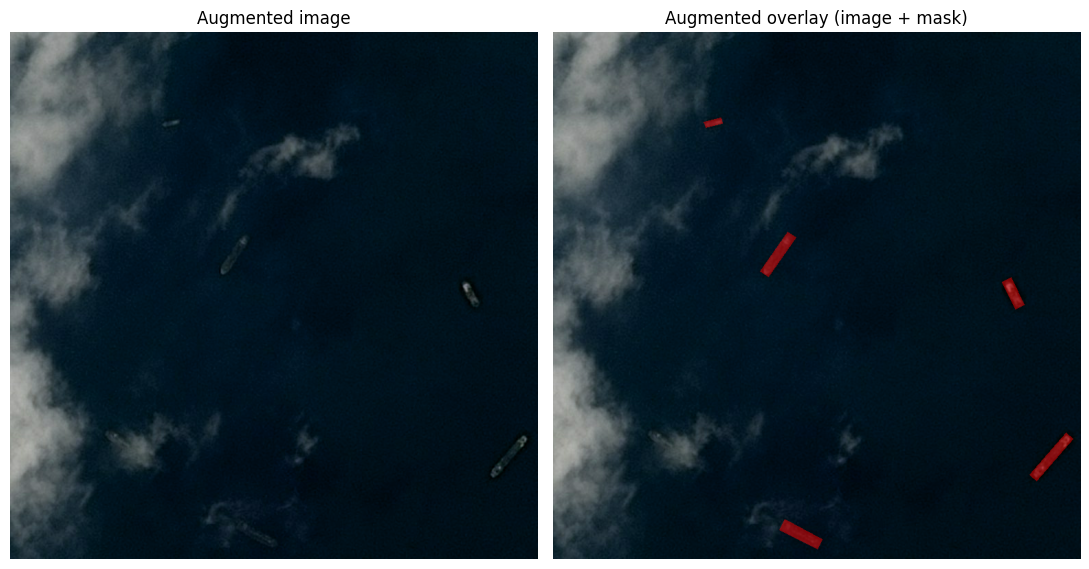

In [51]:
aug_img, aug_mask = prep.training_augmentation(img, mask)

aug_overlay = make_overlay(aug_img, aug_mask)

fig, axes = plt.subplots(1, 2, figsize=(11, 9))

# Row 1
axes[0].imshow(aug_img)
axes[0].set_title("Augmented image")
axes[0].axis("off")

axes[1].imshow(aug_overlay)
axes[1].set_title("Augmented overlay (image + mask)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Test-time augmentations ###

We create 7 augmented versions of the original image:
- horizontal flip
- vertical flip
- horizontal & vertical flip
- 90° rotation (on oridinal and and horizontall flipped)
- 270° rotation (on oridinal and and horizontall flipped)

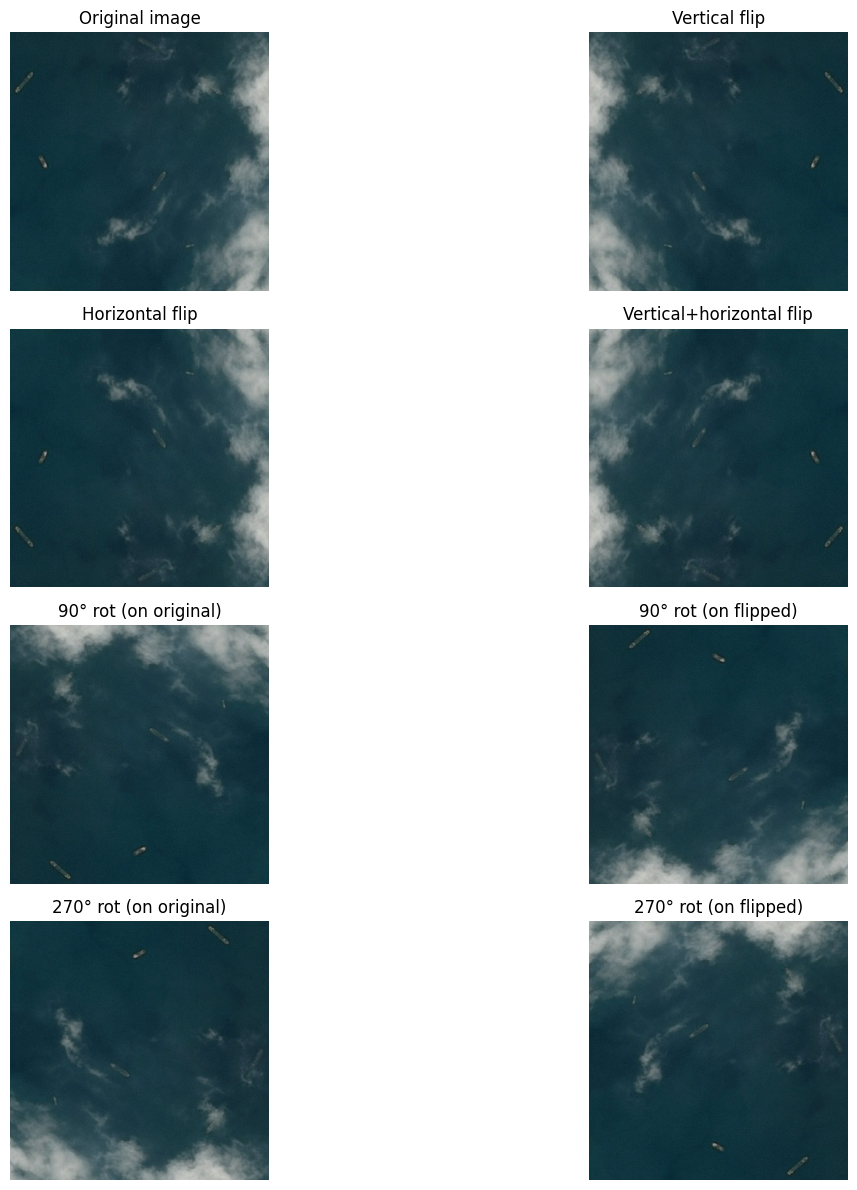

In [52]:
tta_images = prep.test_augmentation(img)

fig, axes = plt.subplots(4, 2, figsize=(15, 12))

# Row 1
axes[0, 0].imshow(tta_images[0])
axes[0, 0].set_title("Original image")
axes[0, 0].axis("off")

axes[0, 1].imshow(tta_images[1])
axes[0, 1].set_title("Vertical flip")
axes[0, 1].axis("off")

# Row 2
axes[1, 0].imshow(tta_images[2])
axes[1, 0].set_title("Horizontal flip")
axes[1, 0].axis("off")

axes[1, 1].imshow(tta_images[3])
axes[1, 1].set_title("Vertical+horizontal flip")
axes[1, 1].axis("off")

# Row 3
axes[2, 0].imshow(tta_images[4])
axes[2, 0].set_title("90° rot (on original)")
axes[2, 0].axis("off")

axes[2, 1].imshow(tta_images[5])
axes[2, 1].set_title("90° rot (on flipped)")
axes[2, 1].axis("off")

# Row 4
axes[3, 0].imshow(tta_images[6])
axes[3, 0].set_title("270° rot (on original)")
axes[3, 0].axis("off")

axes[3, 1].imshow(tta_images[7])
axes[3, 1].set_title("270° rot (on flipped)")
axes[3, 1].axis("off")

plt.tight_layout()
plt.show()